## Outline

##### Paper

Frey, Dueck (2007) <i>Clustering by Passing Messages Between Data Points</i>

##### Overview
- Clustering algorithm
- Each data point is node in network
- Messages sent between nodes
- Data points have "affinity" for neighbors as "exemplars" (similar to cluster centroids)
- Exemplars are iteratively chosen through message-passing procedure between data points

##### Input
- Input is similarity $s(i, k)$ for points $i$ and $k$...
    - i.e. $s(i, k) = -\Vert x_i - x_k \Vert^2$
    
    
- ...and "preferences" $s(k, k)$
    - Diagonal elements of $s$-matrix
    - Larger $s(k, k) \rightarrow$ more likely to be chosen as exemplar
    - Under equal prior preference for all points, scale of shared value determines # of clusters
    
##### Algorithm Setup
- Two types of messages are passed
    1. "Responsibility" $r(i, k)$ from $i$ to $k$
        - "...accumulated evidence for how well-suited point $k$ is to serve as the exemplar for point $i$..."
        - Accounts for other potential exemplars for $i$
    2. "Availability" $a(i, k)$ from $k$ to $i$
        - "...accumulated evidence for how appropriate it would be for point $i$ to choose point $k$ as its exemplar..."
        - Accounts for support from other points that point $k$ should be an exemplar
        - Initialize $a(i, k) = 0$
        
##### Algorithm Steps
- At each step...
    1. Update responsibility:
    $$r(i, k) \leftarrow s(i, k) - \underset{k' \text{s.t.} k' \neq k}{\max} \left\{ a(i, k') + s(i, k') \right\}$$
    
    2. Update availability for $i \neq k$:
    $$a(i, k) \leftarrow \min \left\{ 0, r(k, k) + \hspace{-15px} \sum\limits_{i' \text{s.t.} i' \not\in \{i, k\}} \hspace{-10px} \max \{0, r(i', k)\} \right\}$$
    
    3. Update self-availability:
    $$a(k, k) \leftarrow \hspace{-15px} \sum\limits_{i' \text{s.t.} i' \neq k} \hspace{-10px} \max \{0, r(i', k)\}$$
    
    4. Assign exemplars:
        - For point $i$, the value of $k$ that maximizes $a(i, k) + r(i, k)$ either...
            - If $i=k$, identifies $i$ as an exemplar
            - If $i \neq k$, identifies $k$ as the exemplar for point $i$
        
    
- Algorithm may terminate after...
    - Fixed iterations
    - Changes in messages fall below threshold
    - Local decisions stay constant for a number of iterations
    
    
- Apply damping to messages
    - Avoids oscillations
    - Each message is $\lambda$ times previous value plus $1-\lambda$ times update value
        - $\lambda \in [0, 1]$ with default $\lambda = 0.5$
        

- In summary, AP consists of the following steps:
    1. Updating all responsibilities given availabilities
    2. Updating all availabilities given responsibilities
    3. Combining availabilities and responsibilities to monitor exemplar decisions
    4. Terminate algorithm if stopping condition met, otherwise go to 1.

## Implementation

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from numba import njit, prange

In [769]:
np.random.seed(1234)

size = 100

# cluster 1
c1 = np.random.multivariate_normal(
    mean=np.array([0, -0.5]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# cluster 2
c2 = np.random.multivariate_normal(
    mean=np.array([1, -1]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# cluster 3
c3 = np.random.multivariate_normal(
    mean=np.array([3, 1]),
    cov=np.array([
        [0.1, 0],
        [0, 0.1]
    ]),
    size=size
)

# combined data
c = np.r_[c1, c2, c3]

# sample size
n = len(c)

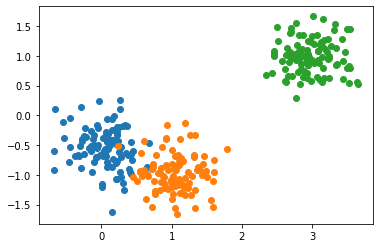

In [770]:
# separate clusters
plt.scatter(*c1.T)
plt.scatter(*c2.T)
plt.scatter(*c3.T)
plt.show()

In [771]:
# preference and similarity
p = 1. * np.ones(n)
s = -distance_matrix(c, c) + np.diag(p)

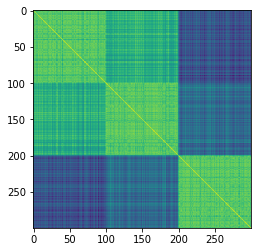

In [772]:
plt.imshow(s)
plt.show()

In [773]:
def update_responsibility_naive(r, s, a, lmb=0.5):
    """Naive responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    for i in range(n):
        for k in range(n):
            max_sum = np.max(np.delete(a[i, :] + s[i, :], k))
            r[i, k] = lmb * r[i, k] + (1 - lmb) * (s[i, k] - max_sum)
    return r

In [774]:
@njit(parallel=True)
def update_responsibility_numba(r, s, a, lmb=0.5):
    """Numba responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    for i in prange(n):
        for k in prange(n):
            max_sum = np.max(np.delete(a[i, :] + s[i, :], k))
            r[i, k] = lmb * r[i, k] + (1 - lmb) * (s[i, k] - max_sum)
    return r

In [775]:
def update_responsibility_numpy(r, s, a, lmb=0.5):
    """Numpy optimized responsibility matrix computation.
    
    Parameters:
        r (np.ndarray) : responsibility matrix
        s (np.ndarray) : similarity matrix
        a (np.ndarray) : availability matrix
        lmb (float)    : damping factor
    
    Returns:
        r (np.ndarray) : updated responsibility matrix
    """
    n = len(s)
    i = np.arange(n)
    temp = np.add(a, s)
    
    # indices of two largest row vals
    idx = np.argpartition(temp, -2)[:, [-1, -2]]
    idx_1 = idx[:, 0]
    idx_2 = idx[:, 1]
    
    # two largest row vals
    max_1 = temp[i, idx_1]
    max_2 = temp[i, idx_2]
    
    # compute responsibility
    np.subtract(s, max_1[:, None], temp)
    temp[i, idx_1] = s[i, idx_1] - max_2
    
    return r * lmb + (1-lmb) * temp

In [777]:
a = np.zeros((n, n))
r = np.zeros_like(a)

# naive implementation
%timeit -r3 -n5 update_responsibility_naive(r, s, a)
print()

# numba implementation
%timeit -r3 -n5 update_responsibility_numba(r, s, a)
print()

# numpy implementation
%timeit -r3 -n5 update_responsibility_numpy(r, s, a)

829 ms ± 8.61 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)

19.4 ms ± 233 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)

810 µs ± 79.1 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)
